In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from matplotlib import font_manager
font_manager.fontManager.addfont("C:\Windows\Fonts\FiraSans-Regular.ttf")

sns.set_theme()
sns.set(font="Fira Sans")

df = pd.read_csv('datasets/merged.csv')
%config InlineBackend.figure_format = 'retina'

## Classical models
We first drop NAs, then perform a train-test split.

In [2]:
from sklearn.model_selection import train_test_split

df = df.dropna(subset=["zhvi_2021"])

fields = ["B01002_001E", "B01003_001E", "B08134_001E", "B15012_001E", "B19013_001E", "B19083_001E", "B23025_005E", "B25001_001E", "B25002_002E", "B25018_001E", "B25035_001E", "B25040_002E", "B25081_001E"]

race_cols = ["B02001_002E", "B02001_003E", "B02001_004E", "B02001_005E", "B02001_006E", "B02001_007E", "B02001_008E", "B02001_009E", "B02001_010E"]

X_cols = fields + ["ALAND", "AWATER", "INTPTLAT", "INTPTLONG"]
y_cols = ["zhvi_2021"]

X_train, X_test, y_train, y_test = train_test_split(
    df[X_cols], df[y_cols], test_size=0.25, random_state=42)

In [3]:
X_train

,B01002_001E,B01003_001E,B08134_001E,B15012_001E,B19013_001E,B19083_001E,B23025_005E,B25001_001E,B25002_002E,B25018_001E,B25035_001E,B25040_002E,B25081_001E,ALAND,AWATER,INTPTLAT,INTPTLONG
1770,42.7,20680.0,8560.0,0.161025,63279.0,0.3959,0.020019,8886.0,0.906257,6.4,1967,0.402881,0.718659,0.997469,0.002531,42.125118,-91.116914
862,46.3,60521.0,23605.0,0.233754,75851.0,0.4474,0.028354,27987.0,0.864509,5.5,1995,0.057312,0.693250,0.963090,0.036910,32.430149,-97.831677
238,31.6,290965.0,131258.0,0.305638,57359.0,0.4968,0.033887,132398.0,0.888813,5.1,1987,0.082358,0.468036,0.952458,0.047542,30.459310,-84.277800
1563,44.8,25808.0,9587.0,0.130696,54506.0,0.4394,0.023481,12786.0,0.790787,5.7,1986,0.115048,0.581886,0.904550,0.095450,34.348733,-82.963290
2642,33.5,7051.0,2281.0,0.150901,50847.0,0.4511,0.055453,2828.0,0.794908,5.5,1971,0.380127,0.494696,0.997351,0.002649,48.428282,-108.967648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,40.5,23861.0,9476.0,0.109006,48481.0,0.4419,0.020326,10182.0,0.868690,5.8,1980,0.230308,0.669711,0.984683,0.015317,37.477859,-86.844871
1095,42.4,43655.0,17642.0,0.090436,45046.0,0.4570,0.037453,20531.0,0.837076,5.6,1983,0.086698,0.592957,0.991726,0.008274,34.637018,-80.159227
1130,40.6,42156.0,18594.0,0.403193,116351.0,0.5044,0.010509,25827.0,0.521741,5.8,1993,0.442792,0.414605,0.994541,0.005459,40.872060,-110.968486
1294,41.6,34906.0,16480.0,0.160431,61309.0,0.4282,0.018020,16558.0,0.872026,5.8,1971,0.490337,0.596388,0.995736,0.004264,41.050322,-100.744481


### Linear regression

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

reg = make_pipeline(StandardScaler(), LinearRegression())
reg.fit(X_train, np.ravel(y_train))
print(f"Score: {reg.score(X_test, y_test):.4g}")
y_pred = reg.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.5e}")

Score: 0.7673
MSE: 4.19756e+09


### Linear regression with SGD

In [43]:
from sklearn.linear_model import SGDRegressor

reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X_train, np.ravel(y_train))
print(f"Score: {reg.score(X_test, y_test):.4g}")
y_pred = reg.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.5e}")

Score: 0.7677
MSE: 4.18989e+09


### Ridge regression

In [6]:
from sklearn.linear_model import Ridge

reg = make_pipeline(StandardScaler(), Ridge(alpha=0.5))
reg.fit(X_train, np.ravel(y_train))
print(f"Score: {reg.score(X_test, y_test):.4g}")
y_pred = reg.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.5e}")

Score: 0.7675
MSE: 4.19385e+09


### Gradient Boosting regression
TODO: cross-validation to select hyperparameters

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

params = {
    "n_estimators": 300,
    "max_depth": 10,
    "min_samples_split": 5,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train, np.ravel(y_train))

print(f"Score: {reg.score(X_test, y_test):.4g}") # Score: 0.863
y_pred = reg.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.5e}") # MSE: 2.47022e+09

Score: 0.8612
MSE: 2.50378e+09


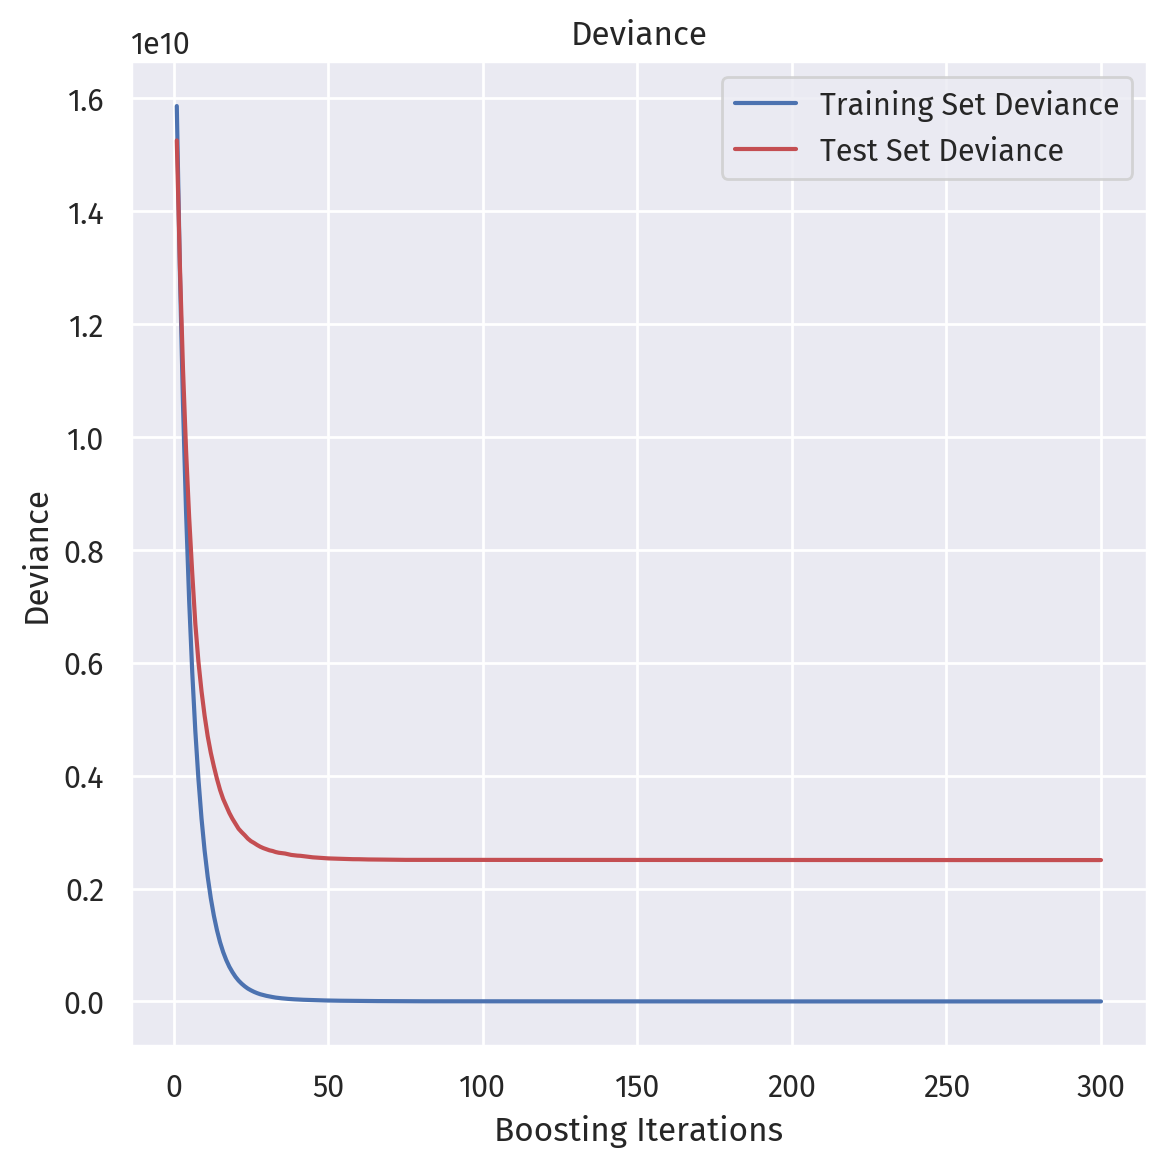

In [8]:
import matplotlib.pyplot as plt

test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

### Support Vector Machines

In [9]:
from sklearn.svm import SVR

regr = make_pipeline(StandardScaler(), SVR(
    kernel="rbf", C=1e7, gamma=0.1, epsilon=0.1, cache_size=1000
    ))
regr.fit(X_train, np.ravel(y_train))
print(f"Score: {regr.score(X_test, y_test):.4g}")
y_pred = regr.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.5e}")

Score: 0.7327
MSE: 4.82056e+09


### Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor

regr = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=20, random_state=42))
regr.fit(X_train, np.ravel(y_train))
print(f"Score: {regr.score(X_test, y_test):.4g}")
y_pred = regr.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.5e}")

Score: 0.9109
MSE: 1.60781e+09


For classical methods, we will be using Random Forest for better interpretability.

### Feature Importance
Here, `feature_importances_` is not used due to reasons outlined [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_).

TODO: investigate [feature importance with correlation](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py).

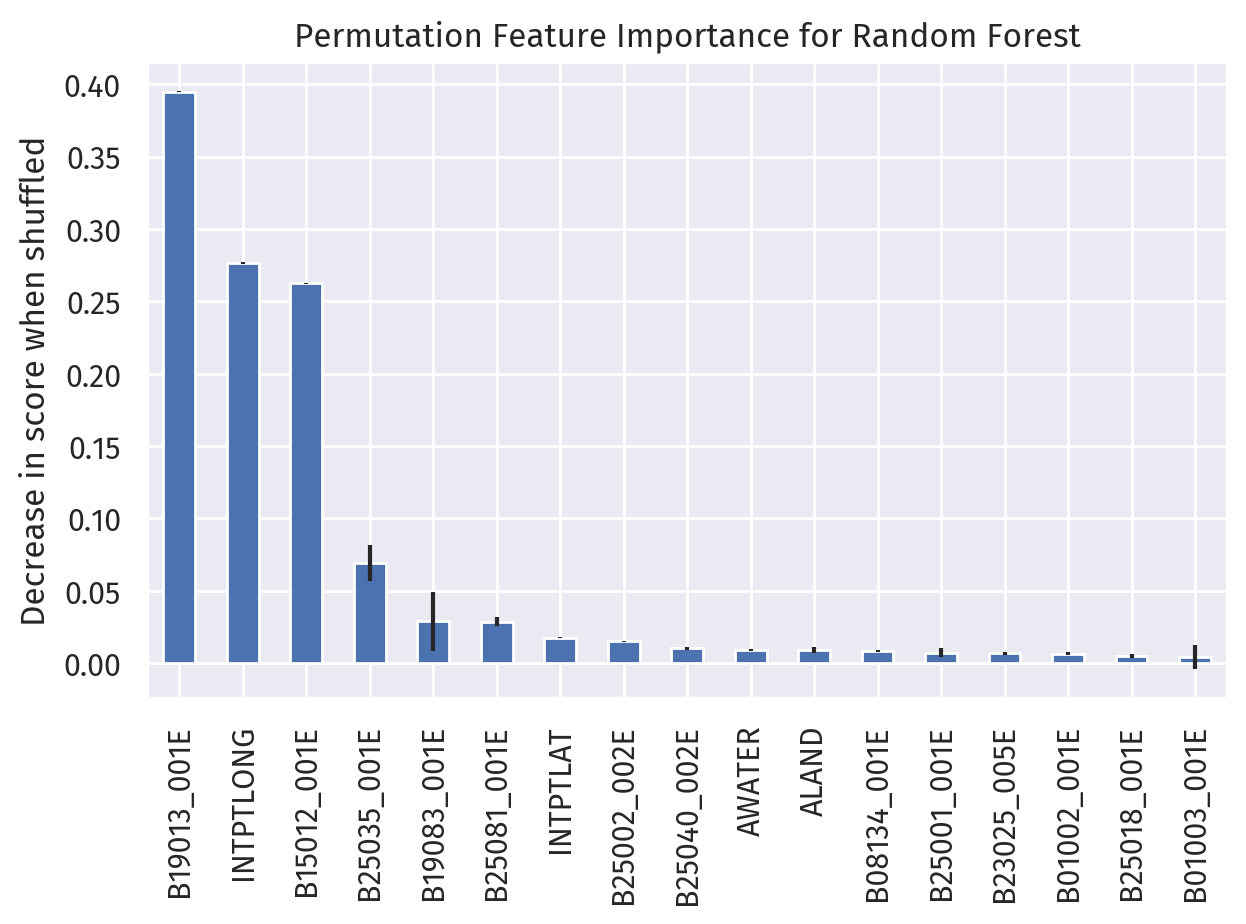

In [11]:
from sklearn.inspection import permutation_importance

per_imp = permutation_importance(regr, X_train, y_train, n_repeats=10, random_state=42)

# imps = pd.Series(regr[1].feature_importances_, index=X_train.columns).sort_values()
imps = pd.Series(per_imp.importances_mean, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
imps.plot.bar(yerr=per_imp.importances_std, ax=ax)
ax.set_title("Permutation Feature Importance for Random Forest")
ax.set_ylabel("Decrease in score when shuffled")
fig.tight_layout()

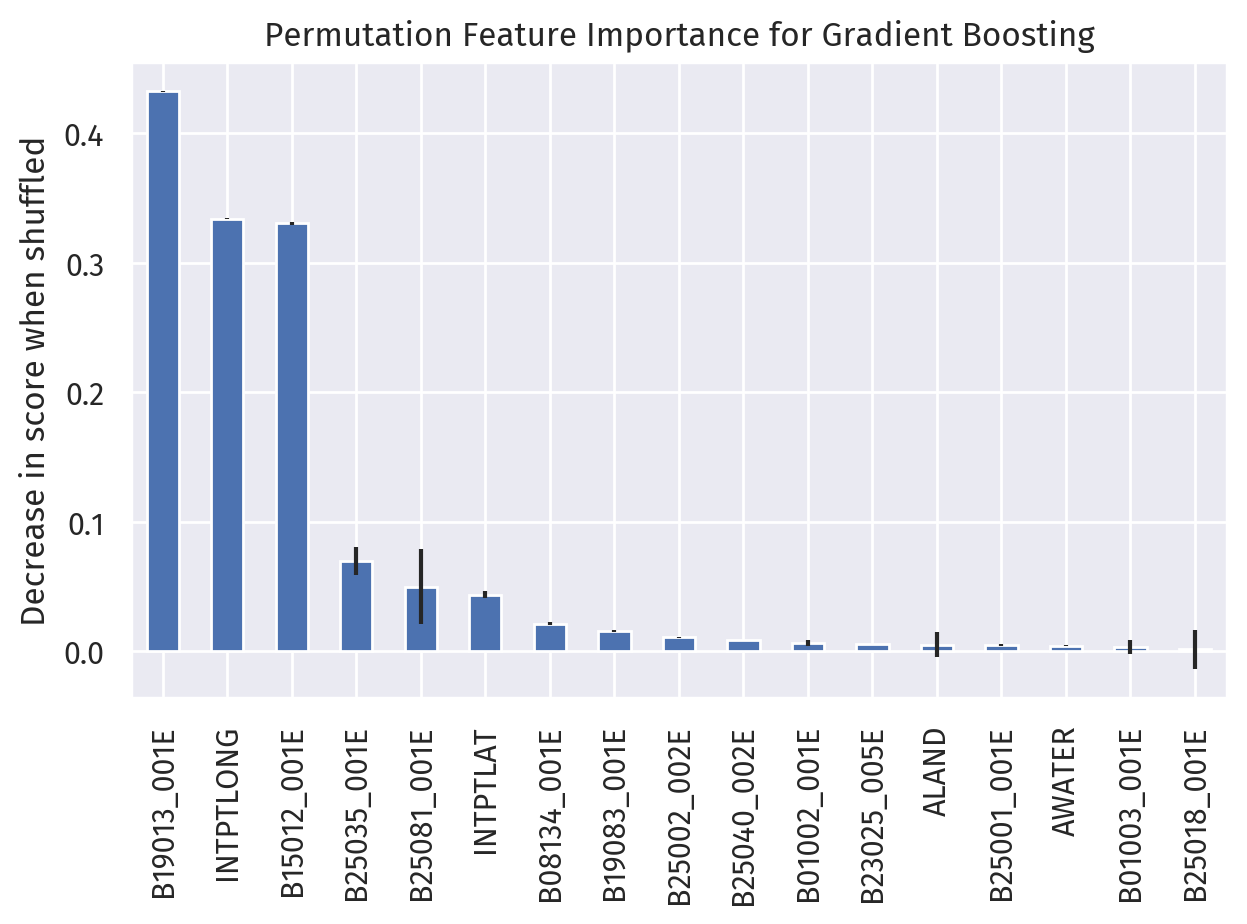

In [12]:
per_imp = permutation_importance(reg, X_train, y_train, n_repeats=10, random_state=42)

# imps = pd.Series(regr[1].feature_importances_, index=X_train.columns).sort_values()
imps = pd.Series(per_imp.importances_mean, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
imps.plot.bar(yerr=per_imp.importances_std, ax=ax)
ax.set_title("Permutation Feature Importance for Gradient Boosting")
ax.set_ylabel("Decrease in score when shuffled")
fig.tight_layout()

### Multicollinear Features

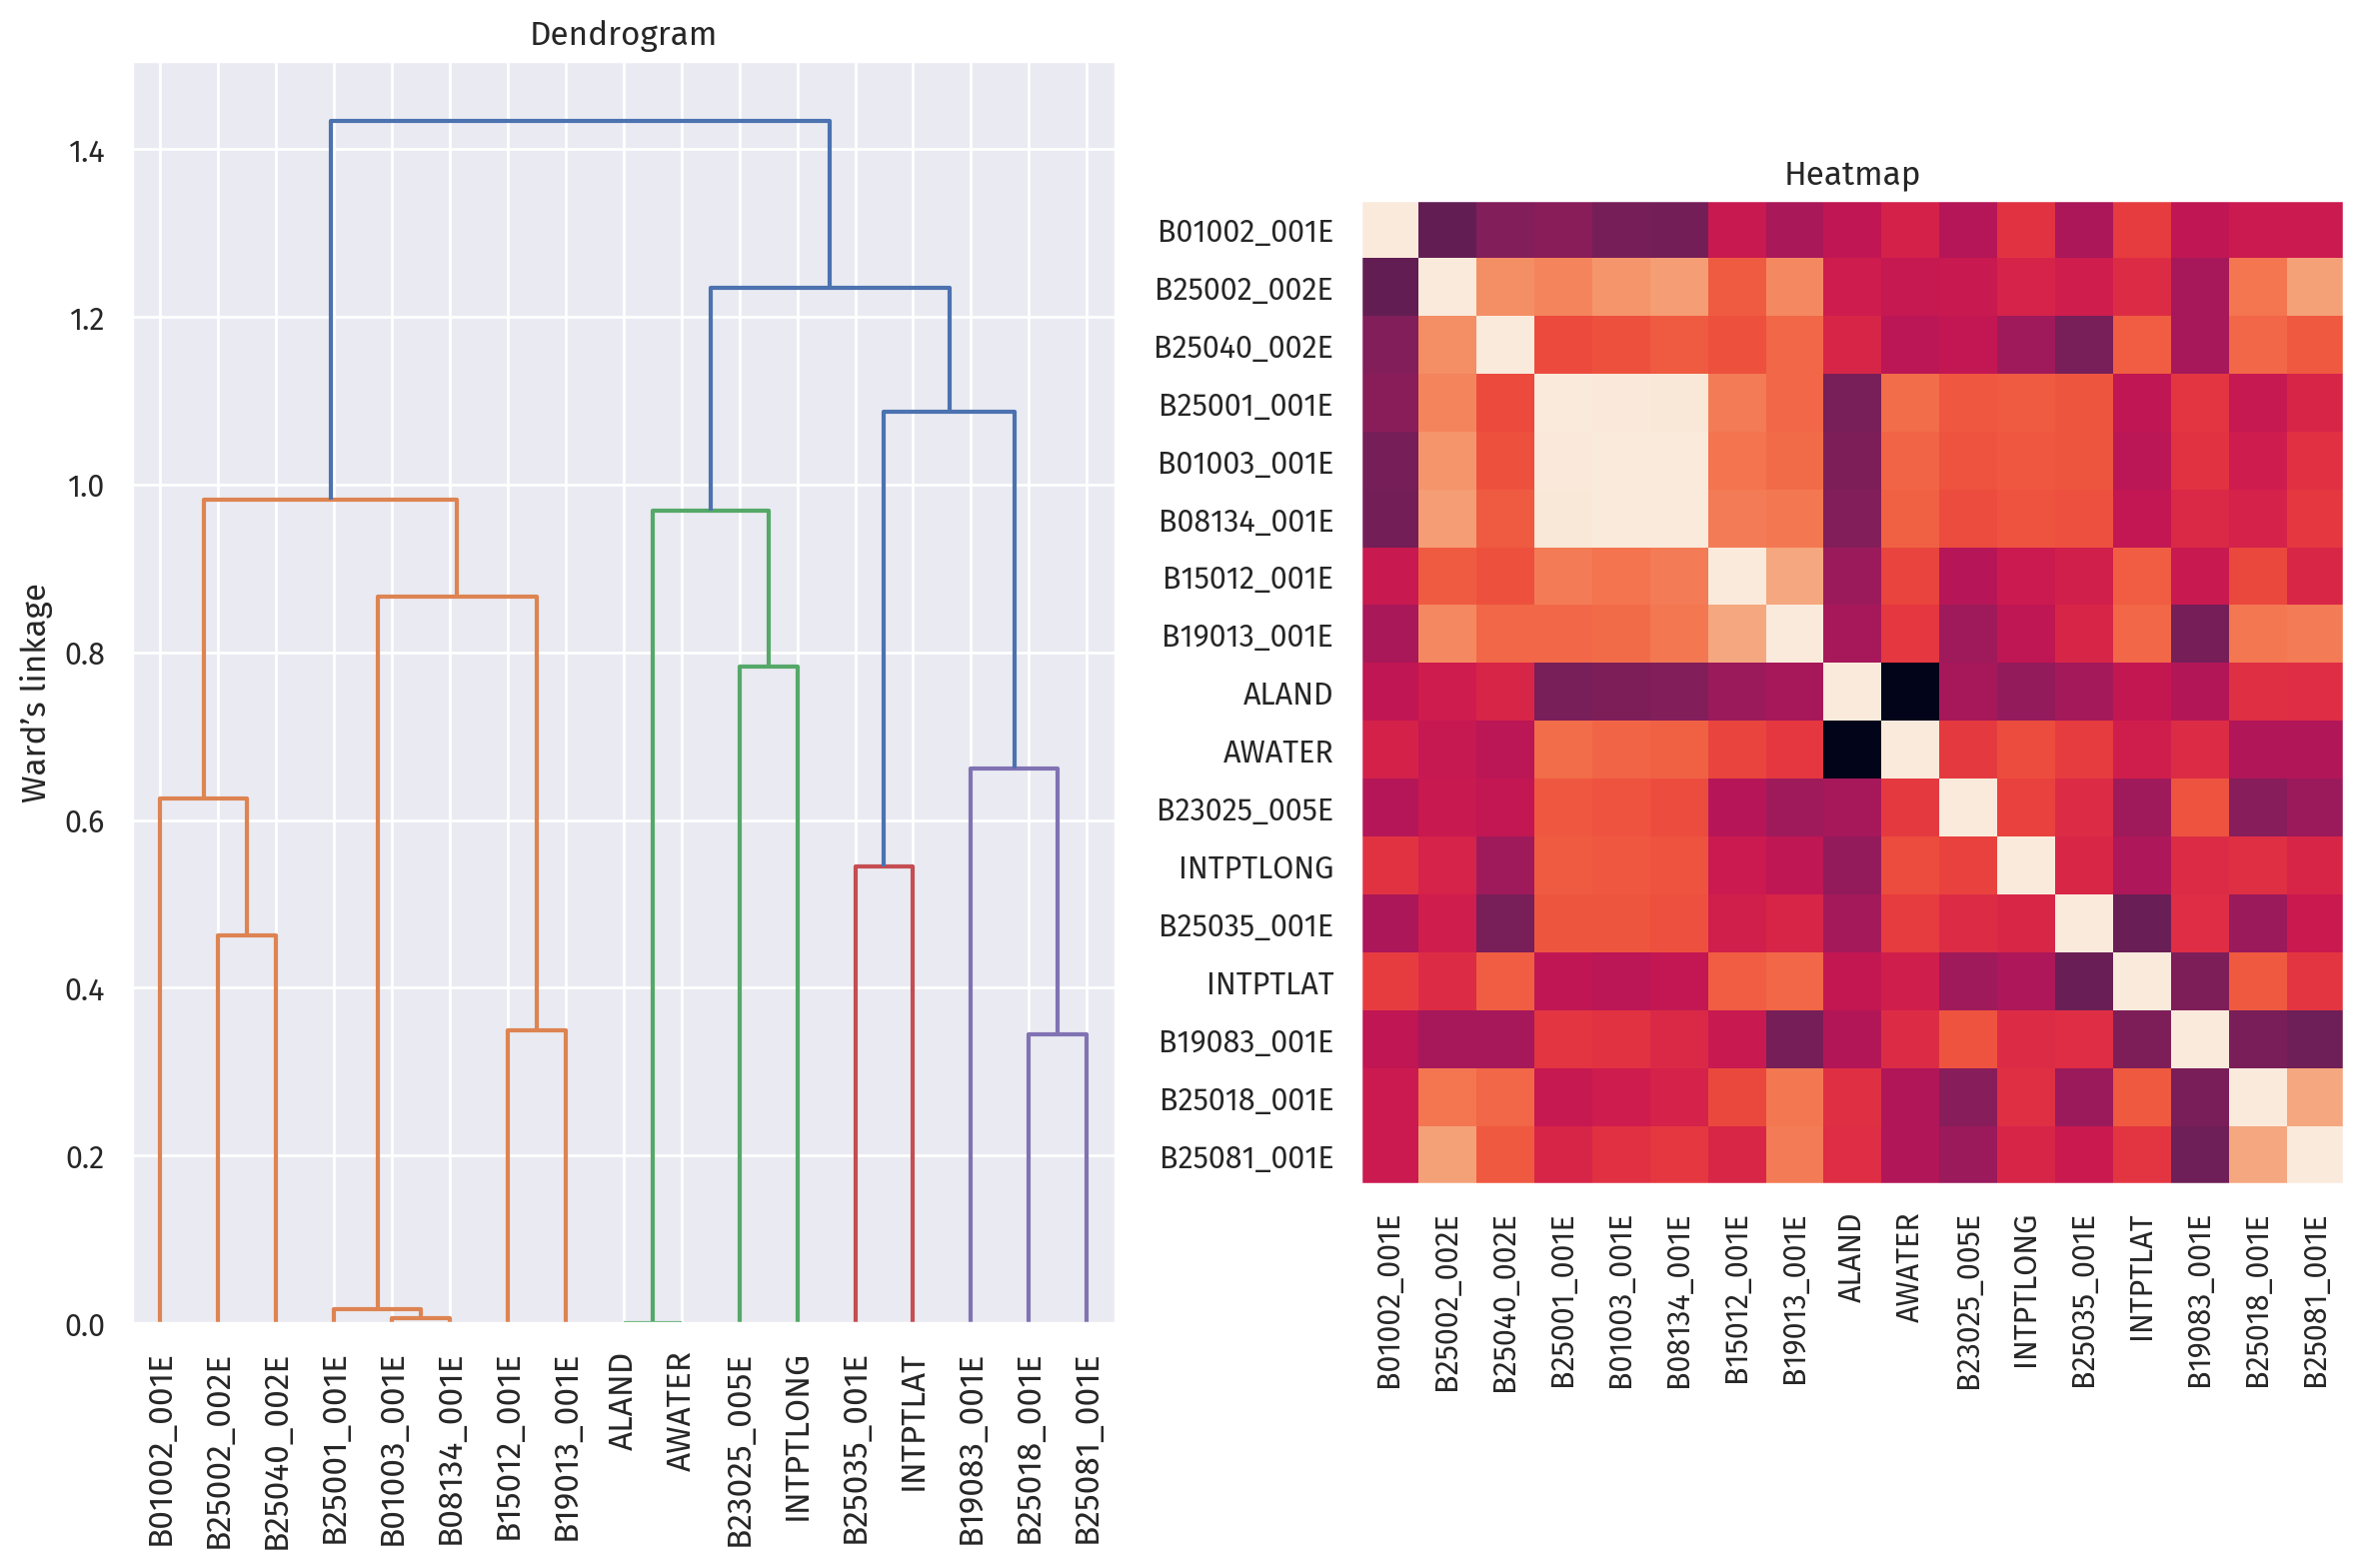

In [13]:
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax1.set_title("Dendrogram")
ax1.set_ylabel("Ward’s linkage")

ax2.set_title("Heatmap")
ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
ax2.grid(False)
fig.tight_layout()
plt.show()

In [14]:
threshold = 1.4
selected_features = []
for i, d in zip(dendro["ivl"], hierarchy.maxdists(dist_linkage)):
    if d < threshold:
        selected_features.append(i)

X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

In [15]:
regr = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=20, random_state=42))
regr.fit(X_train_reduced, np.ravel(y_train))
print(f"Score: {regr.score(X_test_reduced, y_test):.4g}")
y_pred = regr.predict(X_test_reduced)
print(f"MSE: {mean_squared_error(y_test, y_pred):.5e}")

Score: 0.9043
MSE: 1.72617e+09
